In [1]:
##################################
### Import the usual libraries ###
##################################

### Numpy
import numpy as np

### Astropy
import astropy

#Astropy FITS/Table handling
from astropy.io import fits, ascii
from astropy.table import Table, Column

### Pandas
import pandas as pd

### Matplotlib
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 18}) #make plots more readable

# # ### Yumi's RA/DEC ---> Magellanic Stream Coorindates
# import MagellanicStream as ms

### Functions used in this code
import age_functions as afunc
import extinction as extinct
l_eff = {'BP':0.5387,'G':0.6419,'RP':0.7667,'J':1.2345,'H':1.6393,'K':2.1757} # mircons

### Stuff Writtten by A Really Cool Professor
from dlnpyutils import utils as dln

### Other
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm_notebook

In [2]:
def add_noise(quant,quant_err,distribution='normal'):
    '''
    Add noise to data and return new values
    
    Parameters:
    ----------
        quant: 1d array-like data to add noise to
        quant_err: 1d array-like object of errors for quant
        distribution: which distribution to use 'normal', 'poisson', 'uniform'
    
    return: 
    ------
        1d array-like object of data with added noise
    
    '''
    if distribution == 'normal':
        return np.random.normal(quant,quant_err)
    if distribution == 'poisson':
        return quant + np.random.poisson(quant_err)
    if distribution == 'uniform':
        return np.random.uniform(-quant_err+quant,quant+quant_err)

In [3]:
gcs = fits.getdata('/Users/joshuapovick/Desktop/Research/fits/allStar-r13-l33-58932beta_apa_dist_galvel_gc.fits',1)
cln = np.where((gcs['FE_H']>-9999.0)&(gcs['AK_TARG']>-9999.0)&(gcs['LOGG']>0.0)&(gcs['M_H_ERR']>-90.0)&
                (gcs['C_FE']>-9999.0)&(gcs['N_FE']>-9999.0))
gcs = Table(gcs[cln])


harris_dist = [4.5,4.4,6.4,4.8,7.1,10.4,8.8,11.5,3.2,10.2,2.2,7.5,17.9,26.5,5.4,10.3,4.0,12.9,8.3,12.1,9.6,8.9,
               4.9,8.6,19.3,17.4,16.0,8.9,30.5,9.5,5.9,10.4,9.9,2.3,11.6,7.7,3.0,10.9,8.1,8.7,4.0,7.4,23.2,5.8,
               8.2,7.1,10.9,5.2]
harris_ebv = [0.04,0.28,0.33,0.19,0.02,0.10,0.38,0.10,0.34,0.01,0.35,0.03,0.02,0.15,0.08,0.05,0.25,0.01,0.02,0.02,
              0.22,0.03,0.24,0.05,0.02,0.01,0.00,0.36,0.01,0.36,0.54,0.54,0.37,0.18,0.47,0.48,0.76,0.53,0.40,0.05,
              0.04,0.77,0.03,1.46,1.24,1.76,1.17,0.12]

gcs['harris_dist'] = np.zeros(len(gcs))
gcs['harris_ebv'] = -9999.0*np.ones(len(gcs))

for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    gcs['harris_dist'][clus] = harris_dist[i]
    gcs['harris_ebv'][clus] = harris_ebv[i]

In [4]:
### Find Cluster with more than one star

idx = []
for i in range(len(np.unique(gcs['CLUSTER']))):
    idx.append(np.squeeze(np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])))

for i in range(len(idx)):
    try:
        len(idx[i])
    except:
        print('bad: ',i)

bad:  24
bad:  27
bad:  37


In [5]:
### Find Clusters with more than 10 stars

good_names = []
for i in np.asarray(idx)[np.delete(np.asarray(list(range(len(idx)))),[24,27,37])]:
    if len(i)>10:
        good_names.append(gcs['CLUSTER'][i][0])

print(good_names)

['47Tuc', 'M10', 'M107', 'M12', 'M13', 'M19', 'M2', 'M22', 'M3', 'M4', 'M5', 'M53', 'M54', 'M55', 'M71', 'M79', 'NGC1851', 'NGC2808', 'NGC288', 'NGC3201', 'NGC362', 'NGC6388', 'NGC6397', 'NGC6752', 'omegaCen']


In [6]:
good_clus = np.where((gcs['CLUSTER']=='47Tuc')|(gcs['CLUSTER']=='M10')|(gcs['CLUSTER']=='M107')|
                     (gcs['CLUSTER']=='M12')|(gcs['CLUSTER']=='M13')|(gcs['CLUSTER']=='M19')|
                     (gcs['CLUSTER']=='M2')|(gcs['CLUSTER']=='M22')|(gcs['CLUSTER']=='M3')|
                     (gcs['CLUSTER']=='M4')|(gcs['CLUSTER']=='M5')|(gcs['CLUSTER']=='M53')|
                     (gcs['CLUSTER']=='M54')|(gcs['CLUSTER']=='M55')|(gcs['CLUSTER']=='M71')|
                     (gcs['CLUSTER']=='M79')|(gcs['CLUSTER']=='NGC1851')|(gcs['CLUSTER']=='NGC2808')|
                     (gcs['CLUSTER']=='NGC288')|(gcs['CLUSTER']=='NGC3201')|(gcs['CLUSTER']=='NGC362')|
                     (gcs['CLUSTER']=='NGGC6388')|(gcs['CLUSTER']=='NGC6397')|(gcs['CLUSTER']=='NGC6752')|
                     (gcs['CLUSTER']=='omegaCen'))

gcs = gcs[good_clus]

In [7]:
parsec = pd.read_csv('/Users/joshuapovick/Desktop/Research/parsec/parsec12e9.dat',comment='#',
                     names=["Zini","MH","logAge","Mini","int_IMF","Mass","logL","logTe","logg","label","McoreTP",
                            "C_O","period0","period1","period2","period3","period4","pmode","Mloss","tau1m","X",
                            "Y","Xc","Xn","Xo","Cexcess","Z","mbolmag","Gmag","G_BPmag","G_RPmag","B_Tmag",
                            "V_Tmag","Jmag","Hmag","Ksmag"],sep='\s+')
parsec = Table.from_pandas(parsec) 
parsec = parsec[np.where(parsec['label']==3)]

# massive
massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
massive = massive[np.where(massive['label']==3.0)]

# Calculate intrinsic J-K

In [8]:
def closest(val,dat):
    '''
    find value closest to the given one
    
    Inputs:
    ------
        val: given value to find/get closest to
        dat: vals to search through
    '''
    val = np.asarray(val)
    dat = np.asarray(dat)
    
    abs_diff = np.abs(dat - val)
    return dat[abs_diff.argmin()]

In [9]:
jk_int = []
for i in tqdm_notebook(range(len(gcs))):
    jk_int.append(extinct.parsec_teff_2_jk(gcs['TEFF'][i],gcs['FE_H'][i],12.5,parsec))

jk_int = np.asarray(jk_int)
ejk = gcs['J']-gcs['K'] - jk_int

print('negative/total: ',len(np.squeeze(np.where(ejk<0)))/len(gcs))


negative/total:  0.09201557935735151


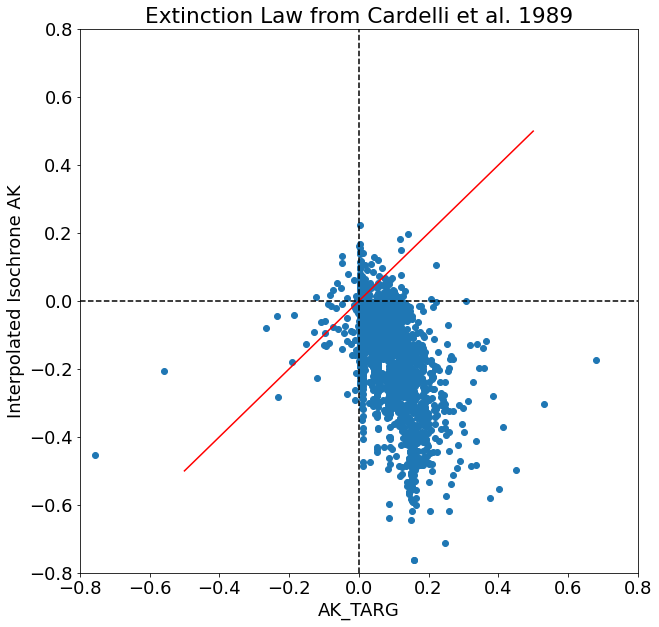

In [10]:
akejk = extinct.cardelli_alav(1/2.190,3.1)/extinct.cardelli_e12av(1/1.220,1/2.190,3.1)

plt.figure(figsize=[10,10])

plt.scatter(gcs['AK_TARG'],(ejk*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'Interpolated Isochrone AK')
plt.show()

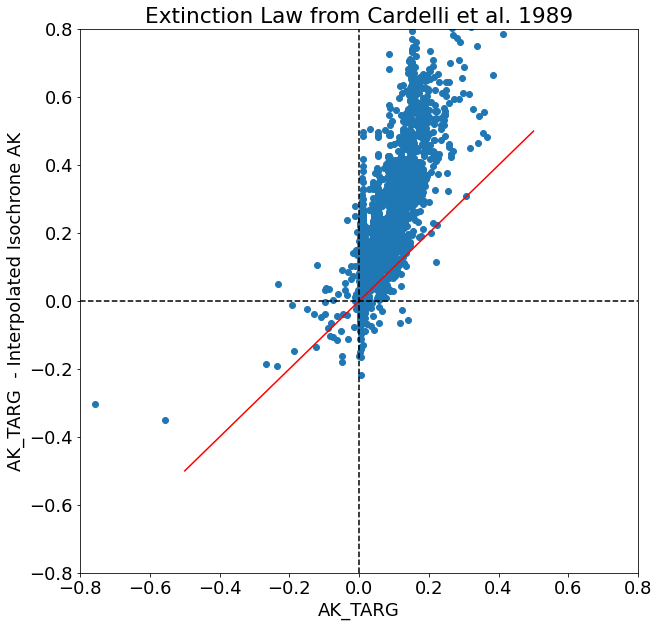

In [11]:
plt.figure(figsize=[10,10])

plt.scatter(gcs['AK_TARG'],gcs['AK_TARG']-(ejk*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.8,0.8)
plt.ylim(-0.8,0.8)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'AK_TARG')
plt.ylabel(r'AK_TARG  - Interpolated Isochrone AK')
plt.show()

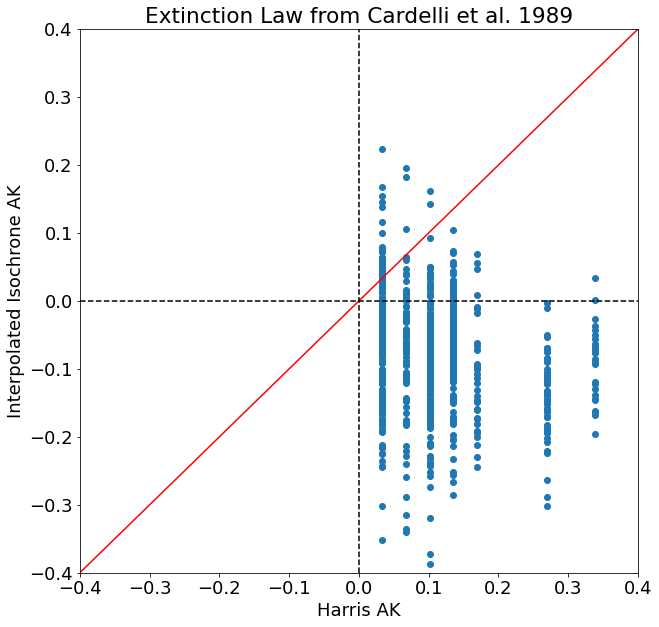

In [12]:
harris_ak = gcs['harris_ebv']*extinct.cardelli_alebv(1/2.190,3.1)

plt.figure(figsize=[10,10])

plt.scatter(harris_ak,(ejk*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'Harris AK')
plt.ylabel(r'Interpolated Isochrone AK')
plt.show()

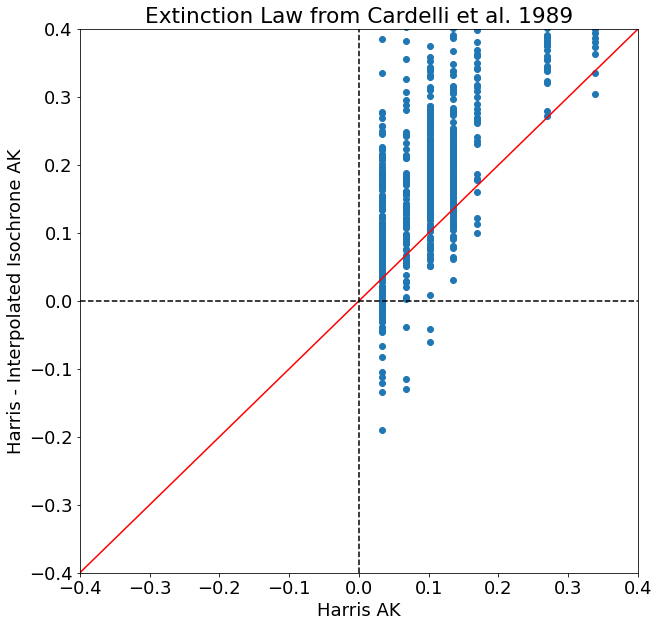

In [13]:
plt.figure(figsize=[10,10])

plt.scatter(harris_ak,harris_ak-(ejk*akejk).data)
plt.plot([-0.5,0.5],[-0.5,0.5],c='r')

plt.axvline(0.0,c='k',ls='--')
plt.axhline(0.0,c='k',ls='--')

plt.xlim(-0.4,0.4)
plt.ylim(-0.4,0.4)

plt.title(r'Extinction Law from Cardelli et al. 1989')
plt.xlabel(r'Harris AK')
plt.ylabel(r'Harris - Interpolated Isochrone AK')
plt.show()

In [14]:
### M4 
'''
Hendricks et al. 2012
Rv = 3.6 
E(B-V) = 0.37 +/- 
'''
print('E(J-K) Calculated: {:.3f}'.format(np.median(ejk[np.where(gcs['CLUSTER']=='M4')])))
print('E(J-K) Rv=3.1: {:.3f} +/-{:.3f}'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.37,
                                               extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.01))
print('E(J-K) Rv=3.6: {:.3f} +/-{:.3f}'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*0.37,
                                               extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*0.01))
print('Harris Value: {:.3f}'.format(
    extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*np.median(gcs['harris_ebv'][np.where(gcs['CLUSTER']=='M4')])))



E(J-K) Calculated: 0.255
E(J-K) Rv=3.1: -0.796 +/--0.022
E(J-K) Rv=3.6: -0.841 +/--0.023
Harris Value: -0.796


In [15]:
### 47Tuc
'''
Salaris and Girardi 2002 
Rv = 
E(B-V) = 0.02 +/- 0.02 
'''

print('E(J-K) Calculated: {:.3f}'.format(np.median(ejk[np.where(gcs['CLUSTER']=='47Tuc')])))
print('E(J-K) Rv=3.1: {:.3f} +/-{:.3f}'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.02,
                                               extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.02))
print('Harris Value: {:.3f}'.format(
    extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*np.median(gcs['harris_ebv'][np.where(gcs['CLUSTER']=='47Tuc')])))

E(J-K) Calculated: 0.023
E(J-K) Rv=3.1: -0.043 +/--0.043
Harris Value: -0.091


In [16]:
### NGC3201
'''
Layden and Sarajedini 2003
Rv = 
E(B-V) = 0.25+/-0.02
'''

print('E(J-K) Calculated: {:.3f}'.format(np.median(ejk[np.where(gcs['CLUSTER']=='NGC3201')])))
print('E(J-K) Rv=3.1: {:.3f} +/-{:.3f}'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.25,
                                               extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.02))
print('Harris Value: {:.3f}'.format(
    extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*np.median(gcs['harris_ebv'][np.where(gcs['CLUSTER']=='NGC3201')])))

E(J-K) Calculated: 0.130
E(J-K) Rv=3.1: -0.538 +/--0.043
Harris Value: -0.546


In [17]:
### NGC3201
'''
Brasseur et al. 2010
Rv = 
E(B-V) = 0.25+/-0.02
'''

print('E(J-K) Calculated: {:.3f}'.format(np.median(ejk[np.where(gcs['CLUSTER']=='NGC1851')])))
print('E(J-K) Rv=3.1: {:.3f} +/-'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.034)),
#                                                extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.02))
print('Harris Value: {:.3f}'.format(
    extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*np.median(gcs['harris_ebv'][np.where(gcs['CLUSTER']=='NGC1851')])))

E(J-K) Calculated: 0.061
E(J-K) Rv=3.1: -0.073 +/-
Harris Value: -0.045


In [18]:
### M13
'''
Brasseur et al. 2010
Rv = 
E(B-V) = 0.016+/-
'''

print('E(J-K) Calculated: {:.3f}'.format(np.median(ejk[np.where(gcs['CLUSTER']=='M13')])))
print('E(J-K) Rv=3.1: {:.3f} +/-'.format(extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.016)),
#                                                extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*0.02))
print('Harris Value: {:.3f}'.format(
    extinct.cardelli_e12ebv(1/1.220,1/2.190,3.6)*np.median(gcs['harris_ebv'][np.where(gcs['CLUSTER']=='M13')])))

E(J-K) Calculated: 0.032
E(J-K) Rv=3.1: -0.034 +/-
Harris Value: -0.045


In [19]:
'''
Rv does make a difference
'''

print('Cluster Interpolated Harris')
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    print('{}: {:.3f} {:.3f}'.format(np.unique(gcs['CLUSTER'])[i],np.median(((ejk*akejk).data[clus])),
                                     extinct.cardelli_e12ebv(1/1.220,1/2.190,3.1)*np.median(gcs['harris_ebv'][clus])))

Cluster Interpolated Harris
47Tuc: -0.042 -0.086
M10: -0.271 -0.602
M107: -0.377 -0.710
M12: -0.195 -0.409
M13: -0.058 -0.043
M19: -0.328 -0.818
M2: -0.080 -0.215
M22: -0.283 -0.732
M3: -0.038 -0.022
M4: -0.464 -0.753
M5: -0.092 -0.065
M53: -0.063 -0.043
M54: -0.156 -0.323
M55: -0.139 -0.172
M71: -0.202 -0.538
M79: -0.093 -0.022
NGC1851: -0.110 -0.043
NGC2808: -0.296 -0.473
NGC288: -0.030 -0.065
NGC3201: -0.238 -0.516
NGC362: -0.114 -0.108
NGC6397: -0.168 -0.387
NGC6752: -0.054 -0.086
omegaCen: -0.094 -0.258


In [20]:
# uniq_clus = np.unique(gcs['CLUSTER'])
# uniq_clus

<font size='45'>
    <b>
        CMDs with Literature Values
    </b>
</font>

In [21]:
########################
### Xmatch NGC Names ###
########################

### xmatch with Wagner-Kaiser et al.

supp2 = pd.read_csv('../stx544_Supp/Table2.txt',comment='#',
                    names=['Cluster','Dist','Dist_Sigma','Av','Av_Sigma','[Fe/H]','Age'],sep='\s+')
supp2 = Table.from_pandas(supp2)

ngc_names = []
for i in range(len(gcs)):
    
    #M2: NGC7089
    if (gcs['CLUSTER'][i]=='47Tuc'): 
        ngc_names.append('NGC0104')
    
    #M10: NGC6254
    elif (gcs['CLUSTER'][i]=='M10'): 
        ngc_names.append('NGC6254')
        
    #M107: NGC6171
    elif (gcs['CLUSTER'][i]=='M107'): 
        ngc_names.append('NGC6171')
        
    #M12: NGC6218
    elif (gcs['CLUSTER'][i]=='M12'): 
        ngc_names.append('NGC6218')
        
    #M13: NGC6205
    elif (gcs['CLUSTER'][i]=='M13'): 
        ngc_names.append('NGC6205')
        
    #M19: NGC6273
    elif (gcs['CLUSTER'][i]=='M19'): 
        ngc_names.append('NGC6273')

    #M2: NGC7089
    elif (gcs['CLUSTER'][i]=='M2'): 
        ngc_names.append('NGC7089')
    
    #M22: NGC6656
    elif (gcs['CLUSTER'][i]=='M22'): 
        ngc_names.append('NGC6656')
        
    #M3: NGC5272
    elif (gcs['CLUSTER'][i]=='M3'): 
        ngc_names.append('NGC5272')
        
    #M4: NGC6121
    elif (gcs['CLUSTER'][i]=='M4'): 
        ngc_names.append('NGC6121')
        
    #M5: NGC5904
    elif (gcs['CLUSTER'][i]=='M5'): 
        ngc_names.append('NGC5904')
            
    #M53: NGC5024
    elif (gcs['CLUSTER'][i]=='M53'): 
        ngc_names.append('NGC5024')
    
    #M55: NGC6809
    elif (gcs['CLUSTER'][i]=='M55'): 
        ngc_names.append('NGC6809') 
    
    #M71: NGC6838
    elif (gcs['CLUSTER'][i]=='M71'): 
        ngc_names.append('NGC6838')
        
    #M79: NGC1904
    elif (gcs['CLUSTER'][i]=='M79'): 
        ngc_names.append('NGC1904')
        
    #NGC288: NGC0288
    elif (gcs['CLUSTER'][i]=='NGC288'): 
        ngc_names.append('NGC0288')
        
    #NGC362: NGC0362
    elif (gcs['CLUSTER'][i]=='NGC362'): 
        ngc_names.append('NGC0362')
        
    #omegaCen: NGC5139
    elif (gcs['CLUSTER'][i]=='omegaCen'): 
        ngc_names.append('NGC5139')
    
    else:
        ngc_names.append(gcs['CLUSTER'][i])
        
ngc_names = np.asarray(ngc_names)

### xmatch paper and APOGEE
_, s2_ind, _ = np.intersect1d(supp2['Cluster'], np.unique(ngc_names), return_indices=True)

supp2 = supp2[s2_ind]
# supp2['harris_dist'] = np.array([12.1,9.6,4.9,19.3,10.3,17.9,17.4,5.2,10.2,16.0,7.5,2.2,8.9,6.4,7.1,4.8,4.4,5.9,
#                                  9.9,2.3,11.6,3.2,26.5,8.7,4.0,5.4,4.0,10.4,11.5])
# supp2['harris_feh'] = np.array([-1.18,-1.14,-1.59,-1.80,-2.23,-2.10,-2.27,-1.53,-1.50,-1.98,-1.29,-1.16,-1.76,
#                                 -1.02,-1.53,-1.37,-1.56,-0.45,-0.55,-2.02,-0.46,-1.70,-1.49,-1.10,-1.54,-1.94,
#                                 -0.78,-2.37,-1.65])

# harris_ebv = np.array([0.02,0.22,0.24,0.02,0.05,0.02,0.01,0.12,0.01,0.00,0.03,0.35,0.36,0.33,0.02,0.19,0.28,0.54,
#                       0.37,0.18,0.47,0.34,0.15,0.05,0.04,0.08,0.25,0.10,0.06])

# #see extinction notebook for more
# #ejk/ebv = 0.523927394130361 +/- 0.019165859411484742
# #ak/ejk = 0.4684682866066239 +/- 0.03150382297846413
# #ak/ebv = 0.24360996634482945 +/- 0.01388934883284669

# supp2['harris_ejk'] = harris_ebv*0.523927394130361
# supp2['harris_ak'] = harris_ebv*0.4555635537199514  #*0.24360996634482945

In [22]:
supp2['Cluster']

NGC0104
NGC0288
NGC0362
NGC1851
NGC2808
NGC3201
NGC5024
NGC5139
NGC5272
NGC5904
NGC6121


In [23]:
gcs_feh_med = []
for i in range(len(supp2)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    gcs_feh_med.append(np.median(gcs['FE_H'][clus]))

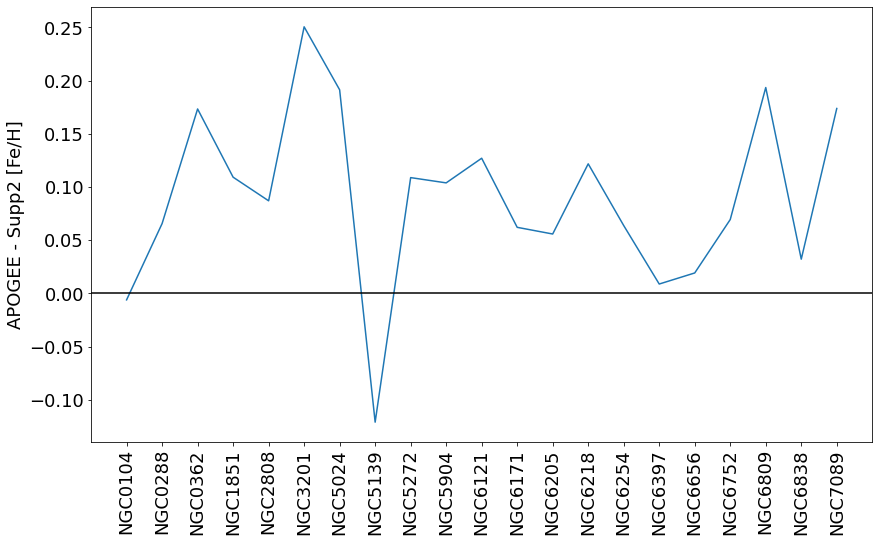

In [24]:
plt.figure(figsize=[14,8])
plt.plot(gcs_feh_med-supp2['[Fe/H]'])
plt.axhline(0.0,c='k')
plt.xticks(np.arange(0.,len(supp2),1.),supp2['Cluster'],rotation=90)
plt.ylabel(r'APOGEE - Supp2 [Fe/H]')
plt.show()

In [25]:
lits_colors = []
lits_kmag = []
for i in tqdm_notebook(range(len(supp2))):
    iso = np.where((massive['logAge']==dln.closest(massive['logAge'],np.log10(supp2['Age'][i]*10**9))[0])&
                   (massive['MH']==dln.closest(massive['MH'],supp2['[Fe/H]'][i])[0]))
    
    lits_colors.append((massive['Jmag']-massive['Ksmag'])[iso])
    lits_kmag.append(massive['Ksmag'][iso])

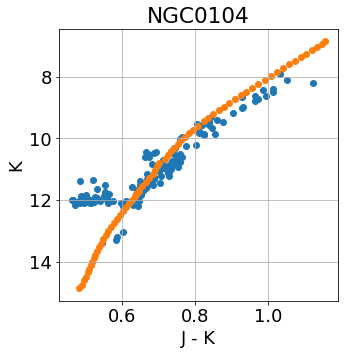

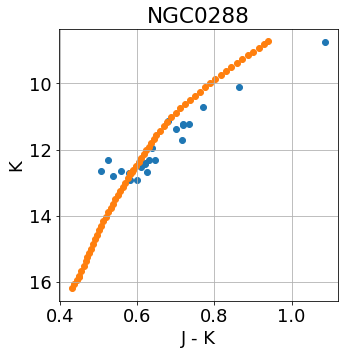

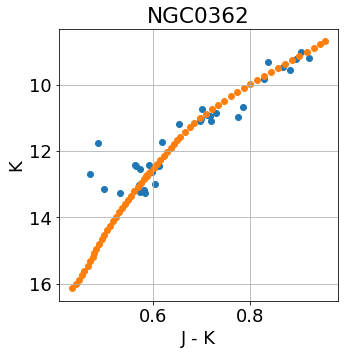

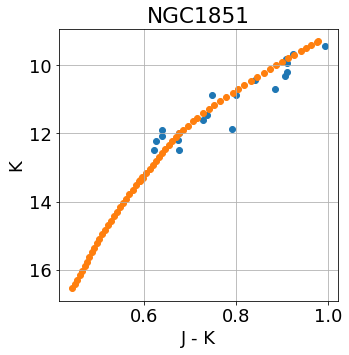

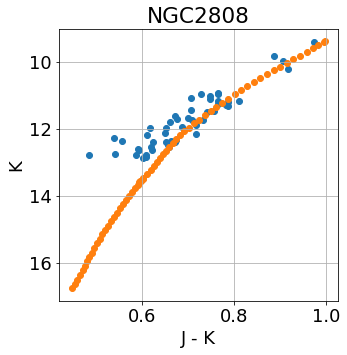

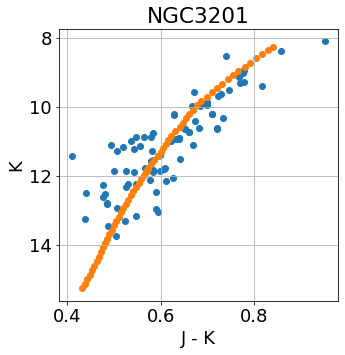

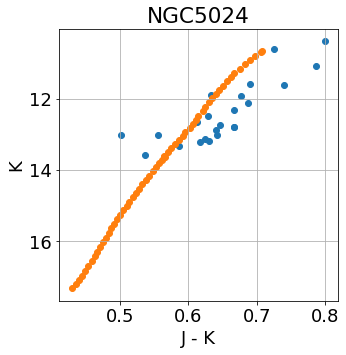

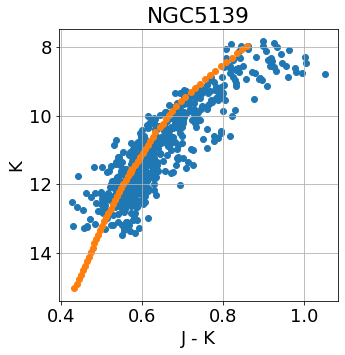

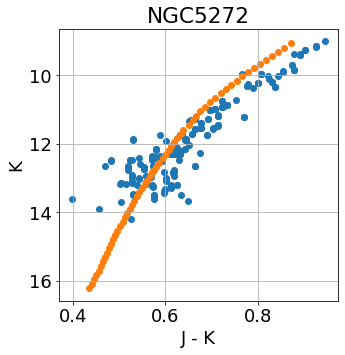

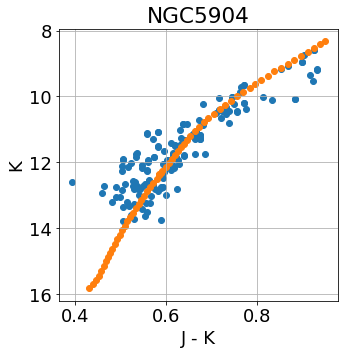

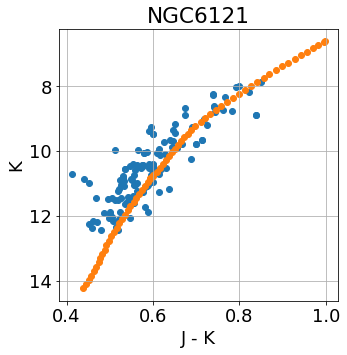

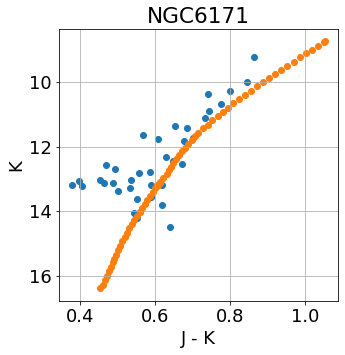

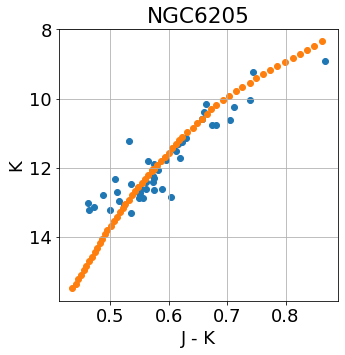

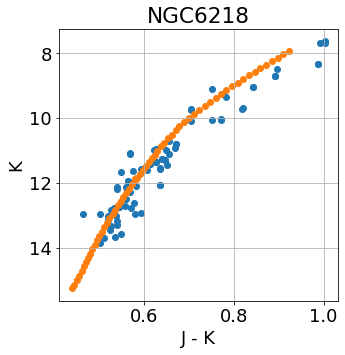

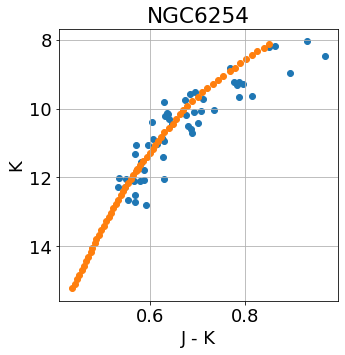

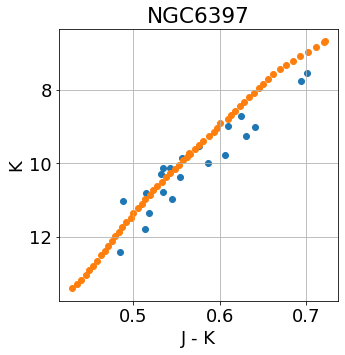

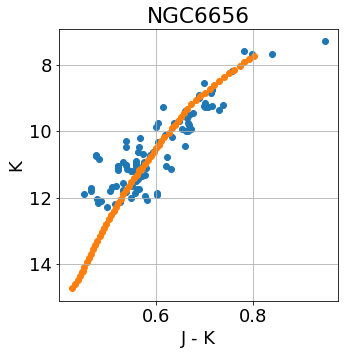

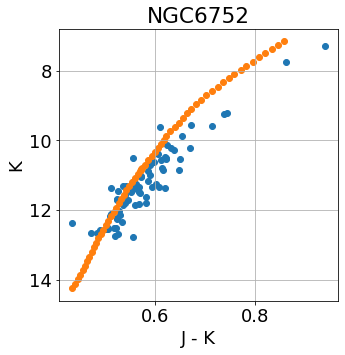

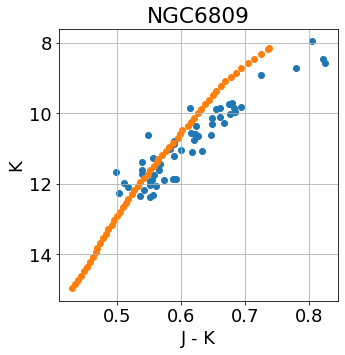

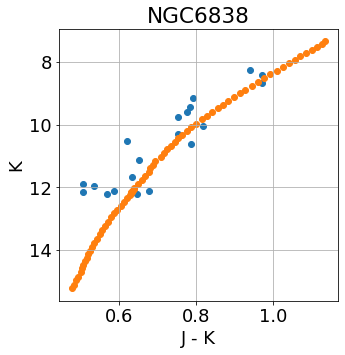

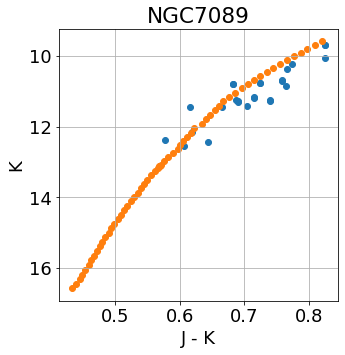

In [26]:
for i in range(len(lits_colors)):
    clus = np.where(ngc_names==supp2['Cluster'][i])
    
    plt.figure(figsize=[5,5])
    
    plt.scatter((gcs['J']-gcs['K'])[clus]-np.median(ejk[clus]),gcs['K'][clus]-(ejk*akejk)[clus])
    
    plt.scatter(lits_colors[i],lits_kmag[i]+supp2['Dist'][i])
    
    plt.gca().invert_yaxis()
    
    plt.grid()
    
    plt.title(supp2['Cluster'][i])
    plt.xlabel(r'J - K')
    plt.ylabel(r'K')
    plt.show()

# Age with Derived Reddening/Extinction from Teff-Color

In [21]:
parsec = ascii.read('/Users/joshuapovick/Desktop/Research/parsec/parsec3_3.dat',format='basic',delimiter='\s')
rgb = np.where(parsec['label']==3)
parsec = parsec[rgb]

def age_model(z1,z2,z3):

    p = [9.38631710e+00,4.57009017e-02,-5.98198867e-02,-2.99642242e+00,1.86921027e-02,-4.51165023e-02,
         1.10829968e-01,-5.93377185e-03,2.51457473e-02,7.98522275e-01,2.26643514e-02,4.00941011e-01]

    age = (p[0]+p[1]*z1+p[2]*z2+p[3]*z3+p[4]*np.multiply(z1,z2)+p[5]*np.multiply(z1,z3)+p[6]*np.multiply(z2,z3)+
           p[7]*(z1**2)+p[8]*(z2**2)+p[9]*(z3**2)+p[10]*(z2**3)+p[11]*(z3**3))
    
    return age
    
### Get Solar Fractions
abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))

In [22]:
age_dist = []

pca_transform = PCA(n_components=3).fit(np.array([parsec['logTe'],parsec['Ksmag'],parsec['MH'],parsec['logg']]).T)

# gcs2 = gcs[np.where((gcs['AL_FE']>-100.)&(gcs['AL_FE']<0.4))]

for i in tqdm_notebook(range(len(np.squeeze(gcs))),desc='Done?'):
    # temperature
    teff = gcs['TEFF'][i]
    teff_err = gcs['TEFF_ERR'][i]
    
    # photometry 
    ra = gcs['RA'][i]
    dec = gcs['DEC'][i]
    ks = gcs['K'][i]
    ks_err = gcs['K_ERR'][i]
    ak = (ejk*akejk)[i] #gcs['AK_TARG'][i]
    dist = gcs['harris_dist'][i] #gcs['distmed'][i]
#     dist_err = #gcs['sigma_dist'][i]
    
    # abundances
    mh = gcs['M_H'][i]
    mh_err = gcs['M_H_ERR'][i]
    cfe = gcs['C_FE'][i]
    cfe_err = gcs['C_FE_ERR'][i]
    nfe = gcs['N_FE'][i]
    nfe_err = gcs['N_FE_ERR'][i]
    feh = gcs['FE_H'][i]
    feh_err = gcs['FE_H_ERR'][i]
    am = gcs['ALPHA_M'][i]
    am_err = gcs['ALPHA_M_ERR'][i]
    
    # surface gravity
    lgg = gcs['LOGG'][i]
    lgg_err = gcs['LOGG_ERR'][i]
    
    noise_ages = []
    new = []
    for j in range(750):
       
        # calculate noisy temperature
        teff_new = add_noise(teff,teff_err) 
        lgteff_new = np.log10(teff_new)
    
        # Calculate noisy K magnitude
        
        ks_new = add_noise(ks,ks_err)
        
        dist_new = dist #add_noise(dist,dist_err)
            
        absK_new = afunc.absmag(ks_new,dist_new) - ak
            
        # Calculate noisy Salaris correction
        
        x_C_new = sol_xm[0]*10**(add_noise(cfe,cfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        x_N_new = sol_xm[1]*10**(add_noise(nfe,nfe_err)+
                                 add_noise(feh,feh_err)-add_noise(mh,mh_err))
        
        ffac_new = (x_C_new+x_N_new)/sum(sol_xm[0:2])
        
        mh_new = add_noise(mh,mh_err)
        am_new = add_noise(am,am_err)
        
        # Calculate noisy surface gravity
        lgg_new = add_noise(lgg,lgg_err)
            
        # calculate noisy age
        new.append(np.array([lgteff_new,absK_new,afunc.sal(mh_new,am_new),lgg_new]))
        
    zs = pca_transform.transform(np.asarray(np.squeeze(new)))

    for l in range(len(zs)):
        noise_ages.append(age_model(zs[l][0],zs[l][1],zs[l][2]))
    
    age_dist.append(noise_ages)

parages = [] 
devs = []
for k in tqdm_notebook(range(len(age_dist))):
    devs.append(afunc.mad(age_dist[k]))
    parages.append(np.median(age_dist[k]))
devs = np.asarray(devs)
parages = np.asarray(parages)

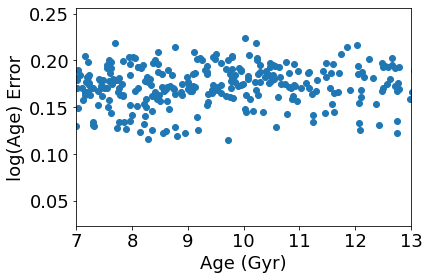

In [42]:
gc_age = []
for i in range(len(parages)):
    gc_age.append(10**parages[i]/10**9)
    
plt.scatter(gc_age,devs)
plt.xlim(7,13)
# plt.title(r'''I don't like this''')
plt.xlabel(r'Age (Gyr)')
plt.ylabel(r'log(Age) Error')
plt.show()

In [66]:

print('Cluster Age (Gyr)')
for i in range(len(np.unique(gcs['CLUSTER']))):
    clus = np.where(gcs['CLUSTER']==np.unique(gcs['CLUSTER'])[i])
    print('{}: {:.3f}'.format(np.unique(gcs['CLUSTER'])[i],np.median(np.asarray(gc_age)[clus])))

Cluster Age (Gyr)
47Tuc: 4.322
M10: 10.254
M107: 2.933
M12: 6.379
M13: 7.119
M19: 2.442
M2: 2.648
M22: 15.832
M3: 5.182
M4: 1.578
M5: 4.035
M53: 15.056
M54: 3.143
M55: 3.902
M71: 4.548
M79: 1.230
NGC1851: 2.106
NGC2808: 2.761
NGC288: 6.236
NGC3201: 5.493
NGC362: 2.182
NGC6397: 13.830
NGC6752: 7.959
omegaCen: 21.836


In [75]:
# massive = fits.getdata('/Users/joshuapovick/Desktop/Research/parsec/parsec_massive.fits.gz',0)
# massive = massive[np.where(massive['label']==3.0)]

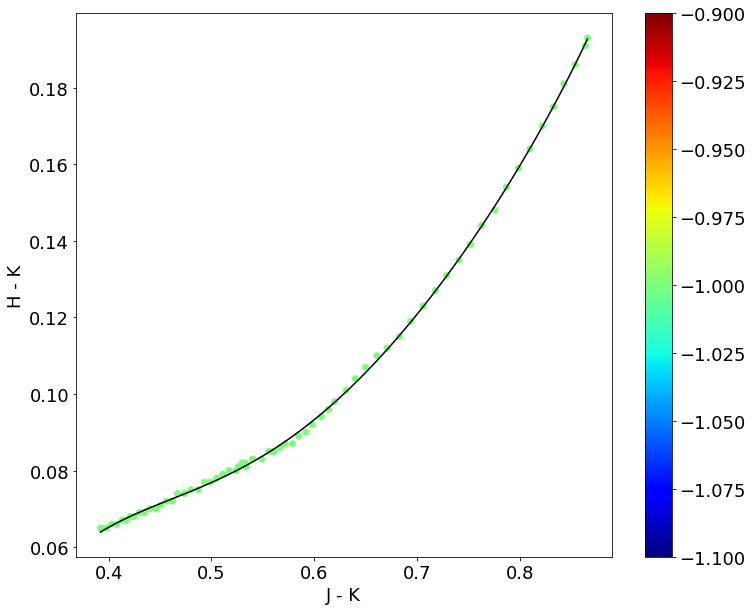

In [89]:
met = np.where((massive['MH']==closest(-1.0,massive['MH']))&(massive['Jmag']-massive['Ksmag']>0.2)&
               (massive['logAge']==closest(np.log10(12*10**9),massive['logAge'])))

exog = (massive['Jmag'] - massive['Hmag'])[met] #av0_1_0['Jmag']-av0_1_0['Ksmag']
endog = (massive['Hmag'] - massive['Ksmag'])[met] #av0_1_0['Hmag']-av0_1_0['Ksmag']

z = np.polyfit(exog, endog, 5)
p = np.poly1d(z)

x = np.linspace(min(exog),max(exog),100)
plt.figure(figsize=[12,10])
plt.scatter(exog,endog,c=massive['MH'][met],cmap='jet')
plt.colorbar()

plt.plot(x,p(x),c='k')
# plt.title(r'[Fe/H] ~ -1.0')
plt.xlabel(r'J - K')
plt.ylabel(r'H - K')
plt.show()

In [83]:
pnt = [0.90,0.10]

In [84]:
z

array([  3.04104914, -12.02163661,  18.65344564, -13.92522755,
         5.09914723,  -0.67447799])

In [88]:
from scipy.optimize import minimize

exog = (massive['Jmag'] - massive['Ksmag'])[met] #av0_1_0['Jmag']-av0_1_0['Ksmag']
endog = (massive['Hmag'] - massive['Ksmag'])[met] #av0_1_0['Hmag']-av0_1_0['Ksmag']

z = np.polyfit(exog, endog, 5)
# p = np.poly1d(z)

In [87]:
z

array([  3.04104914, -12.02163661,  18.65344564, -13.92522755,
         5.09914723,  -0.67447799])